# Downloading models and dataset

In [1]:
import gdown
# Download the trained expert model
!gdown --id 1tqMYda2ltKC_ehC72SX4AiLVCY-N1alo

# Download the trained imitation model
!gdown --id 1VuVeMVWr4uviZx5_a8JacNx2oJdN36_l

# Download the dataset
!gdown --id 1_hA31m6QDd-X5WhqPDfqcE0SHt97Rfy-

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tqMYda2ltKC_ehC72SX4AiLVCY-N1alo
To: /content/reinforce_cartpole.h5
100% 37.8k/37.8k [00:00<00:00, 2.24MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VuVeMVWr4uviZx5_a8JacNx2oJdN36_l
To: /content/cartpole_imitation_model.h5
100% 84.4k/84.4k [00:00<00:00, 25.3MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloa

# Creating dataset of state and action


In [2]:
import gymnasium as gym
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("reinforce_cartpole.h5")

env = gym.make("CartPole-v1")

num_episodes = 10

expert_data = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)

    done = False

    while not done:
        state_input = state.reshape(1, -1)
        action_probs = model.predict(state_input, verbose=0)
        action = np.argmax(action_probs)

        expert_data.append((state, action))

        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        state = np.array(next_state, dtype=np.float32)

expert_data = np.array(expert_data, dtype=object)

np.save("cartpole_expert_data.npy", expert_data)

print(f"Expert dataset saved successfully as 'cartpole_expert_data.npy' ({len(expert_data)} samples).")


Expert dataset saved successfully as 'cartpole_expert_data.npy' (5000 samples).


# Downloading Dataset of state and action

In [3]:
!gdown --id 1_hA31m6QDd-X5WhqPDfqcE0SHt97Rfy-

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_hA31m6QDd-X5WhqPDfqcE0SHt97Rfy-
To: /content/cartpole_expert_data.npy
100% 2.52M/2.52M [00:00<00:00, 80.9MB/s]


# Load dataset

In [4]:
import numpy as np

# Load the dataset
data = np.load("cartpole_expert_data.npy", allow_pickle=True)

# Separate states and actions
states = np.array([item[0] for item in data])  # Extract states
actions = np.array([item[1] for item in data])  # Extract actions

print(f"Loaded dataset with {len(states)} samples.")
print(f"State shape: {states.shape}, Action shape: {actions.shape}")


Loaded dataset with 25000 samples.
State shape: (25000, 4), Action shape: (25000,)


# Train Imitation model using our expert examples

## Training

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(4,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model and store training history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained imitation model
model.save("cartpole_imitation_model.h5")

print("Imitation Learning model trained and saved as 'cartpole_imitation_model.h5'")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8444 - loss: 0.3731 - val_accuracy: 0.8982 - val_loss: 0.2015
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9180 - loss: 0.1825 - val_accuracy: 0.9434 - val_loss: 0.1616
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9402 - loss: 0.1467 - val_accuracy: 0.9580 - val_loss: 0.1328
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9492 - loss: 0.1259 - val_accuracy: 0.9522 - val_loss: 0.1182
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9613 - loss: 0.1049 - val_accuracy: 0.9564 - val_loss: 0.1064
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9672 - loss: 0.0915 - val_accuracy: 0.9728 - val_loss: 0.0875
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9673 - loss: 0.0828 - val_accuracy: 0.9750 - val_loss: 0.0808
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9661 - loss: 0.0787 - val_accuracy: 0.9464 - val_

Imitation Learning model trained and saved as 'cartpole_imitation_model.h5'


## Test our model

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9786 - loss: 0.0580
Test Accuracy: 97.50%


## Training vs Validation loss

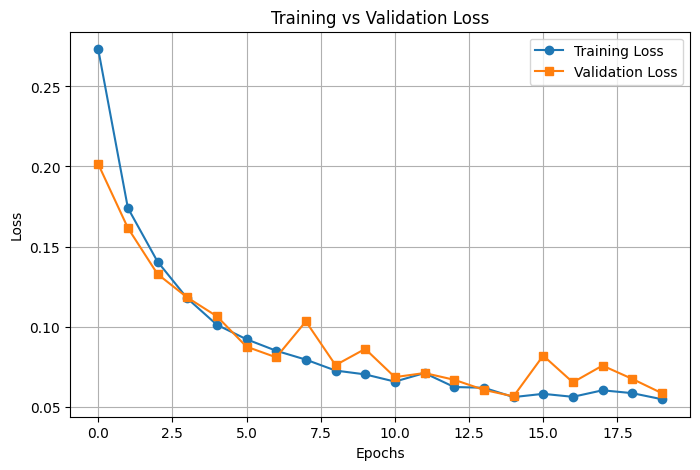

In [7]:
#Plot Training Loss and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Training Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Testing our model

In [8]:
import gymnasium as gym
import numpy as np
import tensorflow as tf

# Download the trained imitation model
!gdown --id 1VuVeMVWr4uviZx5_a8JacNx2oJdN36_l

# Load the trained imitation model
model = tf.keras.models.load_model("cartpole_imitation_model.h5")

# Create the CartPole environment
env = gym.make("CartPole-v1")

num_episodes = 10
total_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)

    done = False
    episode_reward = 0

    while not done:
        state_input = state.reshape(1, -1)

        action_probs = model.predict(state_input, verbose=0)
        action = np.argmax(action_probs)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        state = np.array(next_state, dtype=np.float32)
        episode_reward += reward

        env.render()

    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

env.close()

# Calculate the average score
avg_reward = np.mean(total_rewards)
print(f"Imitation Model Average Reward over {num_episodes} episodes: {avg_reward:.2f}")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VuVeMVWr4uviZx5_a8JacNx2oJdN36_l
To: /content/cartpole_imitation_model.h5
100% 84.4k/84.4k [00:00<00:00, 61.9MB/s]


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 6: Reward = 500.0
Episode 7: Reward = 500.0
Episode 8: Reward = 500.0
Episode 9: Reward = 500.0
Episode 10: Reward = 500.0
Imitation Model Average Reward over 10 episodes: 500.00


# Testing with different dataset size

## Train and test our model over 50 examples

In [9]:
import numpy as np
import tensorflow as tf
import gymnasium as gym

# Load the trained expert model
expert_model = tf.keras.models.load_model("reinforce_cartpole.h5")

# Create the CartPole environment
env = gym.make("CartPole-v1")

num_examples = 50  # Collecting 50 examples
expert_data = []

while len(expert_data) < num_examples:
    state, _ = env.reset()
    done = False

    while not done:
        state_input = np.array(state).reshape(1, -1)

        action_probs = expert_model.predict(state_input, verbose=0)
        action = np.argmax(action_probs)

        expert_data.append((state, action))

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if len(expert_data) >= num_examples:
            break

expert_data = np.array(expert_data, dtype=object)
np.save("expert_data_50.npy", expert_data)

print(f"Collected {len(expert_data)} expert examples and saved as 'expert_data_50.npy'.")


Collected 50 expert examples and saved as 'expert_data_50.npy'.


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9142 - loss: 0.6789 - val_accuracy: 0.8000 - val_loss: 0.6745
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9781 - loss: 0.6535 - val_accuracy: 0.8000 - val_loss: 0.6618
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9590 - loss: 0.6326 - val_accuracy: 0.8000 - val_loss: 0.6485
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9347 - loss: 0.6232 - val_accuracy: 0.8000 - val_loss: 0.6340
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9729 - loss: 0.5871 - val_accuracy: 0.8000 - val_loss: 0.6178
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9781 - loss: 0.5584 - val_accuracy: 0.8000 - val_loss: 0.5989
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9174 - loss: 0.5504 - val_accuracy: 0.8000 - val_loss: 0.5786
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8965 - loss: 0.5235 - val_accuracy: 0.8000 - val_loss: 0.5568

Imitation Learning model trained on 50 examples and saved as 'cartpole_imitation_50.h5'


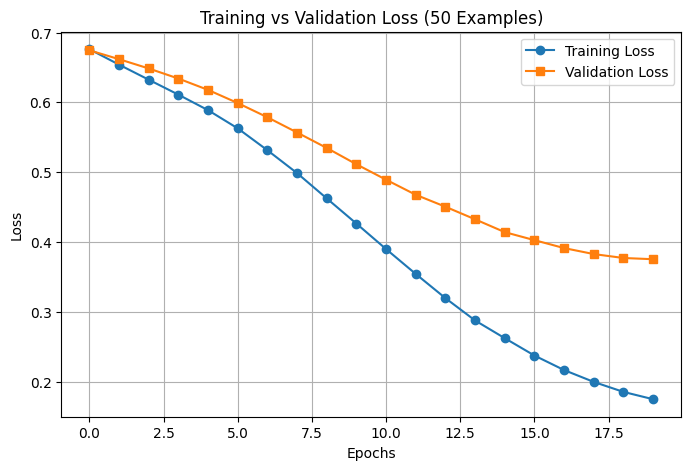

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the expert data (50 examples)
expert_data = np.load("expert_data_50.npy", allow_pickle=True)

states = np.array([item[0] for item in expert_data], dtype=np.float32)
actions = np.array([item[1] for item in expert_data], dtype=np.int32)

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(4,)),  # Input: 4 state values
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")  # Output: 2 actions (left/right)
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

model.save("cartpole_imitation_50.h5")

print("Imitation Learning model trained on 50 examples and saved as 'cartpole_imitation_50.h5'")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Training Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (50 Examples)")
plt.legend()
plt.grid(True)
plt.show()


## Train and test our model over 100 examples

In [11]:
import numpy as np
import tensorflow as tf
import gymnasium as gym

expert_model = tf.keras.models.load_model("reinforce_cartpole.h5")

env = gym.make("CartPole-v1")

num_examples = 100  # Collecting 100 examples
expert_data = []

while len(expert_data) < num_examples:
    state, _ = env.reset()
    done = False

    while not done:
        state_input = np.array(state).reshape(1, -1)

        action_probs = expert_model.predict(state_input, verbose=0)
        action = np.argmax(action_probs)

        expert_data.append((state, action))

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if len(expert_data) >= num_examples:
            break

expert_data = np.array(expert_data, dtype=object)
np.save("expert_data_100.npy", expert_data)

print(f"Collected {len(expert_data)} expert examples and saved as 'expert_data_100.npy'.")


Collected 100 expert examples and saved as 'expert_data_100.npy'.


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6662 - loss: 0.6821 - val_accuracy: 0.9000 - val_loss: 0.6561
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9164 - loss: 0.6397 - val_accuracy: 0.9000 - val_loss: 0.6257
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9676 - loss: 0.5911 - val_accuracy: 0.9000 - val_loss: 0.5855
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9635 - loss: 0.5395 - val_accuracy: 0.9500 - val_loss: 0.5317
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9800 - loss: 0.4844 - val_accuracy: 0.9500 - val_loss: 0.4640
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9251 - loss: 0.4119 - val_accuracy: 0.9500 - val_loss: 0.3987
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9546 - loss: 0.3329 - val_accuracy: 0.9500 - val_loss: 0.3325
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9720 - loss: 0.2975 - val_accuracy: 1.0000 - v

Imitation Learning model trained on 100 examples and saved as 'cartpole_imitation_100.h5'


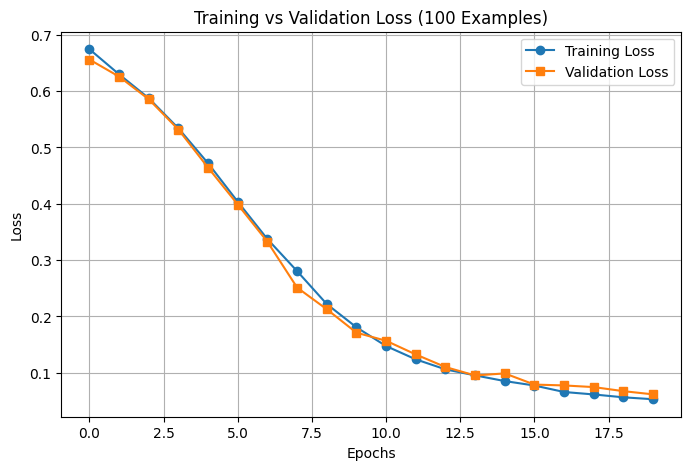

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

expert_data = np.load("expert_data_100.npy", allow_pickle=True)

states = np.array([item[0] for item in expert_data], dtype=np.float32)
actions = np.array([item[1] for item in expert_data], dtype=np.int32)

X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(4,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

model.save("cartpole_imitation_100.h5")

print("Imitation Learning model trained on 100 examples and saved as 'cartpole_imitation_100.h5'")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Training Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (100 Examples)")
plt.legend()
plt.grid(True)
plt.show()


## Train our model over 500 examples

In [13]:
import numpy as np
import tensorflow as tf
import gymnasium as gym

expert_model = tf.keras.models.load_model("reinforce_cartpole.h5")

env = gym.make("CartPole-v1")

num_examples = 500  # Collecting 500 examples
expert_data = []

while len(expert_data) < num_examples:
    state, _ = env.reset()
    done = False

    while not done:
        state_input = np.array(state).reshape(1, -1)
        action_probs = expert_model.predict(state_input, verbose=0)
        action = np.argmax(action_probs)

        expert_data.append((state, action))

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if len(expert_data) >= num_examples:
            break

expert_data = np.array(expert_data, dtype=object)
np.save("expert_data_500.npy", expert_data)

print(f"Collected {len(expert_data)} expert examples and saved as 'expert_data_500.npy'.")


Collected 500 expert examples and saved as 'expert_data_500.npy'.


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7629 - loss: 0.6316 - val_accuracy: 0.8300 - val_loss: 0.4870
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7683 - loss: 0.4464 - val_accuracy: 0.8400 - val_loss: 0.3595
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7289 - loss: 0.3834 - val_accuracy: 0.8400 - val_loss: 0.3341
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7886 - loss: 0.3337 - val_accuracy: 0.8500 - val_loss: 0.3208
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8081 - loss: 0.3026 - val_accuracy: 0.7700 - val_loss: 0.3338
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8214 - loss: 0.3175 - val_accuracy: 0.8400 - val_loss: 0.3163
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8099 - loss: 0.2973 - val_accuracy: 0.8500 - val_loss: 0.3108
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.2883 - val_accuracy: 0.8600 - val_loss:

Imitation Learning model trained on 500 examples and saved as 'cartpole_imitation_500.h5'


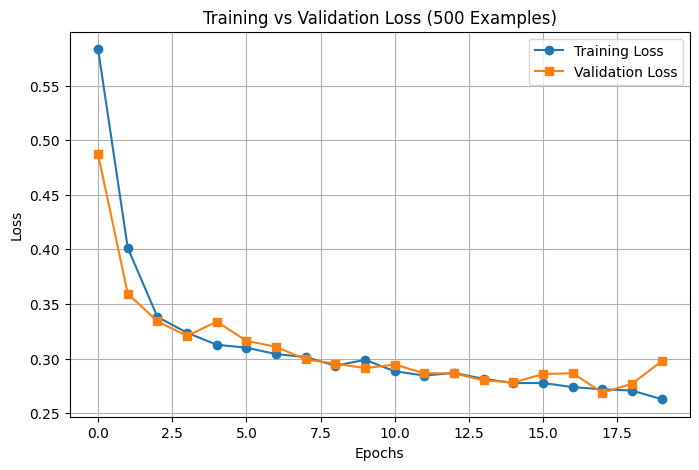

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

expert_data = np.load("expert_data_500.npy", allow_pickle=True)

states = np.array([item[0] for item in expert_data], dtype=np.float32)
actions = np.array([item[1] for item in expert_data], dtype=np.int32)

X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(4,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

model.save("cartpole_imitation_500.h5")

print("Imitation Learning model trained on 500 examples and saved as 'cartpole_imitation_500.h5'")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Training Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (500 Examples)")
plt.legend()
plt.grid(True)
plt.show()


## Traing our model over the 1000 examples

In [15]:
import numpy as np
import tensorflow as tf
import gymnasium as gym

expert_model = tf.keras.models.load_model("reinforce_cartpole.h5")

env = gym.make("CartPole-v1")

num_examples = 1000  # Collecting 100 examples
expert_data = []

while len(expert_data) < num_examples:
    state, _ = env.reset()
    done = False

    while not done:
        state_input = np.array(state).reshape(1, -1)

        action_probs = expert_model.predict(state_input, verbose=0)
        action = np.argmax(action_probs)

        expert_data.append((state, action))

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if len(expert_data) >= num_examples:
            break

expert_data = np.array(expert_data, dtype=object)
np.save("expert_data_1000.npy", expert_data)

print(f"Collected {len(expert_data)} expert examples and saved as 'expert_data_1000.npy'.")


Collected 1000 expert examples and saved as 'expert_data_1000.npy'.


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6502 - loss: 0.6188 - val_accuracy: 0.7750 - val_loss: 0.3655
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7856 - loss: 0.3748 - val_accuracy: 0.8250 - val_loss: 0.3001
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8138 - loss: 0.3117 - val_accuracy: 0.8550 - val_loss: 0.2698
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8152 - loss: 0.3094 - val_accuracy: 0.8350 - val_loss: 0.2638
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8187 - loss: 0.2948 - val_accuracy: 0.8150 - val_loss: 0.2666
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8422 - loss: 0.2722 - val_accuracy: 0.8900 - val_loss: 0.2375
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8333 - loss: 0.2850 - val_accuracy: 0.8250 - val_loss: 0.2494
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8253 - loss: 0.2756 - val_accuracy: 0.

Imitation Learning model trained on 1000 examples and saved as 'cartpole_imitation_1000.h5'


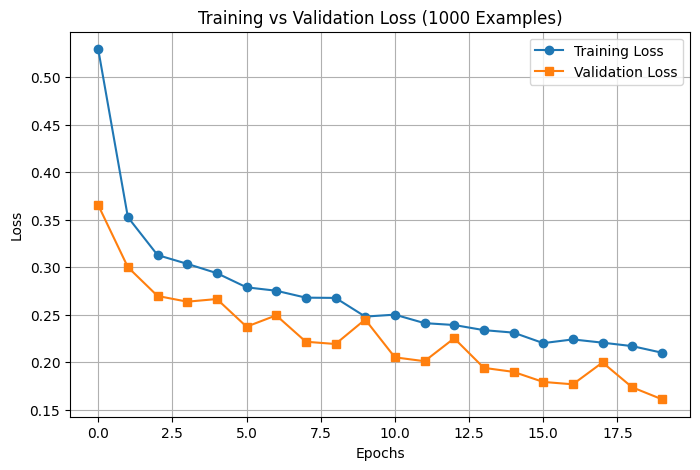

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

expert_data = np.load("expert_data_1000.npy", allow_pickle=True)

states = np.array([item[0] for item in expert_data], dtype=np.float32)
actions = np.array([item[1] for item in expert_data], dtype=np.int32)

X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(4,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

model.save("cartpole_imitation_1000.h5")

print("Imitation Learning model trained on 1000 examples and saved as 'cartpole_imitation_1000.h5'")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Training Loss", marker="o")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (1000 Examples)")
plt.legend()
plt.grid(True)
plt.show()


## Creates Video for each run

In [17]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
import cv2

def record_video(model_path, video_filename, num_episodes=1, fps=30):
    """ Records a video of the model in the CartPole environment and saves it as an MP4 file. """
    # Load the trained imitation model
    model = tf.keras.models.load_model(model_path)

    # Create the environment
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    frame_width = 600
    frame_height = 400

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_filename, fourcc, fps, (frame_width, frame_height))

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # Render frame from environment
            frame = env.render()  # Get image as a NumPy array
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format
            frame = cv2.resize(frame, (frame_width, frame_height))  # Resize
            out.write(frame)  # Save frame to video

            # Prepare model input
            state_input = np.array(state).reshape(1, -1)
            action_probs = model.predict(state_input, verbose=0)
            action = np.argmax(action_probs)

            # Take action in the environment
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    out.release()
    env.close()
    print(f"Video saved as: {video_filename}")

record_video("cartpole_imitation_50.h5", "imitation_video_50.mp4")
record_video("cartpole_imitation_100.h5", "imitation_video_100.mp4")
record_video("cartpole_imitation_500.h5", "imitation_video_500.mp4")
record_video("cartpole_imitation_1000.h5", "imitation_video_1000.mp4")


Video saved as: imitation_video_50.mp4


Video saved as: imitation_video_100.mp4


Video saved as: imitation_video_500.mp4
Video saved as: imitation_video_1000.mp4
